In [7]:
#import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM
from tensorflow.python.keras import regularizers
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from keras.utils import to_categorical
#!{sys.executable} -m pip install keras

# Preprocessing

In [2]:
"""
    Based on the training data given, we are able to extract 7 attributes:
    1. x accelerometer measurement
    2. y accelerometer measurement
    3. z accelerometer measurement
    4. x gyroscope measurement
    5. y gyroscope measurement
    6. z gyroscope measurement
    7. time stamp for accelerometer and gyroscope measures
    
    We start by creating a dataframe using the csv files provided for readability.
    
    @param x_file: contains the xyz accelerometers and xyz gyroscope measures from the lower limb
    @param x_time_file: contain the time stamps for the accelerometer and gyroscope measures
    @return dataframe of 7 attributes mentioned
"""
def create_dataframe_X(x_file, x_time_file):
    df1 = pd.read_csv(x_file, sep = ',', names = ['X_acc', 'Y_acc', 'Z_acc', 'X_gyr', 'Y_gyr', 'Z_gyr'])
    df1 = scale_data(df1, ['X_acc', 'Y_acc', 'Z_acc', 'X_gyr', 'Y_gyr', 'Z_gyr'])
    df2 = pd.read_csv(x_time_file, names = ['Time stamp'])
    frames = [df1, df2]
    result = pd.concat(frames, axis = 1)
    return result

"""
    Scale the values of X to make it robust to outliers.
    
    @param df: input dataframe
    @param columns: columns to scale
    @return scaled dataframe
"""
def scale_data(df, columns):
    scaler = RobustScaler()
    scaler = scaler.fit(df[columns])
    df.loc[:, columns] = scaler.transform(df[columns])
    return df
    
"""
    We have both the labels and the time stamps for the labels. We create a dataframe from these for
    readability.
    
    @param y_file: contain the labels: 
        (0) indicates standing or walking in solid ground, 
        (1) indicates going down the stairs, 
        (2) indicates going up the stairs, and 
        (3) indicates walking on grass
    @param y_time_file: contain the time stamps for the labels
    @return dataframe of labels and time stamps
""" 
def create_dataframe_Y(y_file, y_time_file):
    df1 = pd.read_csv(y_file, names = ['Label'])
    df2 = pd.read_csv(y_time_file, names = ['Time stamp'])
    frames = [df1, df2]
    result = pd.concat(frames, axis = 1)
    return result
    
"""
    We take the outputs of create_dataframe_X and create_dataframe_Y. In order to combine both of these
    dataframes, we need look at the time intervals present for when the labels were assigned. We down-sample
    the X to the shape of the y.
    
    @param x_frame: dataframe from create_dataframe_X
    @param y_frame: dataframe from create_dataframe_Y
    @return dataframe with 9 columns (8 attributes and 1 label)
"""
def combine_frames(x_frame, y_frame):
    # Change each dataframe column to a list for iterations
    time_stamp_y = y_frame['Time stamp'].tolist()
    time_stamp_x = x_frame['Time stamp'].tolist()
    
    x_range = [] # Empty list to append data points to
    x_random_row = 0 # Initializing variable to hold randomly selected row instance
    refs = []
    count = 0
    for i in range(0, len(time_stamp_y)):
        while (time_stamp_x[count] <= time_stamp_y[i]) and (count <= len(time_stamp_x)):
            x_range.append(time_stamp_x.index(time_stamp_x[count]))
            count += 1
        x_random_row = random.choice(x_range) # Pick a random value
        refs.append(x_random_row) # Keep record of selected rows
        x_range.clear() # Clear the cache
        continue
    
    # Create a new dataframe based on the refs collected - should be roughly the same length as the y_frame
    entries = []
    for item in refs:
        entry = x_frame.iloc[item]
        entries.append(entry)
    
    found_df = pd.concat(entries, axis = 1)
    found_df = found_df.transpose()
    
    # Combine found_df with y_frame for downsampling
    found_df = found_df.reset_index()
    found_df = found_df.drop(['index'], axis = 1)
    found_df = found_df.drop(['Time stamp'], axis = 1)
    combined_frame = pd.concat([found_df, y_frame], axis = 1)
    return combined_frame

"""
    Takes in the sequential X and y and creates windows of time-series data.
    
    @param X: input data
    @param y: label data
    @param time_steps: determines size of window
    @param step: incremental value that window will slide over
    @return time series of X and y data
"""
def mode_labels(X, y, time_steps, step):
    X_values = []
    y_values = []
    for i in range(0, len(X) - time_steps, step):
        value = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: (i + time_steps)]
        X_values.append(value)
        y_values.append(stats.mode(labels)[0][0])
    return np.array(X_values), np.array(y_values).reshape(-1, 1)

"""
    Generating data frames from training data.
    
    @param X_file: list of input X files
    @param X_t_file: list of input X_time files
    @param y_file: list of input y files
    @param y_t file: list of y_time files
    @return stacked window of instances across all training files, stack window of labels across all label files
"""
def generate_data(X_file, X_t_file, y_file, y_t_file):
    all_X = []
    all_y = []
    for item_X, item_X_t, item_y, item_y_t in zip(X_file, X_t_file, y_file, y_t_file):
        df_x = create_dataframe_X(item_X, item_X_t)
        df_y = create_dataframe_Y(item_y, item_y_t)
        combined_frame = combine_frames(df_x, df_y)
        X_temp = combined_frame[['X_acc', 'Y_acc', 'Z_acc', 'X_gyr', 'Y_gyr', 'Z_gyr']]
        y_temp = combined_frame['Label']
        X, y = mode_labels(X_temp, y_temp, 30, 1)
        all_X.append(X)
        all_y.append(y)
    return np.concatenate(all_X), np.concatenate(all_y)

In [3]:
# List of training X_files
X_files = ['TrainingData/subject_001_01__x.csv', 'TrainingData/subject_001_02__x.csv', 
           'TrainingData/subject_001_03__x.csv', 'TrainingData/subject_001_04__x.csv',
           'TrainingData/subject_001_05__x.csv', 'TrainingData/subject_001_06__x.csv',
           'TrainingData/subject_001_07__x.csv', 'TrainingData/subject_001_08__x.csv',
           'TrainingData/subject_002_01__x.csv', 'TrainingData/subject_002_02__x.csv',
           'TrainingData/subject_002_03__x.csv', 'TrainingData/subject_001_04__x.csv',
           'TrainingData/subject_002_05__x.csv', 'TrainingData/subject_003_01__x.csv',
           'TrainingData/subject_005_01__x.csv', 'TrainingData/subject_005_02__x.csv',
           'TrainingData/subject_005_03__x.csv', 'TrainingData/subject_006_01__x.csv',
           'TrainingData/subject_006_02__x.csv', 'TrainingData/subject_006_03__x.csv',
           'TrainingData/subject_007_01__x.csv', 'TrainingData/subject_007_02__x.csv',
           'TrainingData/subject_007_03__x.csv', 'TrainingData/subject_007_04__x.csv',
           'TrainingData/subject_008_01__x.csv']

# List of training X_t_files
X_t_files = ['TrainingData/subject_001_01__x_time.csv', 'TrainingData/subject_001_02__x_time.csv', 
             'TrainingData/subject_001_03__x_time.csv', 'TrainingData/subject_001_04__x_time.csv',
             'TrainingData/subject_001_05__x_time.csv', 'TrainingData/subject_001_06__x_time.csv',
             'TrainingData/subject_001_07__x_time.csv', 'TrainingData/subject_001_08__x_time.csv',
             'TrainingData/subject_002_01__x_time.csv', 'TrainingData/subject_002_02__x_time.csv',
             'TrainingData/subject_002_03__x_time.csv', 'TrainingData/subject_001_04__x_time.csv',
             'TrainingData/subject_002_05__x_time.csv', 'TrainingData/subject_003_01__x_time.csv',
             'TrainingData/subject_005_01__x_time.csv', 'TrainingData/subject_005_02__x_time.csv',
             'TrainingData/subject_005_03__x_time.csv', 'TrainingData/subject_006_01__x_time.csv',
             'TrainingData/subject_006_02__x_time.csv', 'TrainingData/subject_006_03__x_time.csv',
             'TrainingData/subject_007_01__x_time.csv', 'TrainingData/subject_007_02__x_time.csv',
             'TrainingData/subject_007_03__x_time.csv', 'TrainingData/subject_007_04__x_time.csv',
             'TrainingData/subject_008_01__x_time.csv']

# List of training y_files
y_files = ['TrainingData/subject_001_01__y.csv', 'TrainingData/subject_001_02__y.csv', 
           'TrainingData/subject_001_03__y.csv', 'TrainingData/subject_001_04__y.csv',
           'TrainingData/subject_001_05__y.csv', 'TrainingData/subject_001_06__y.csv',
           'TrainingData/subject_001_07__y.csv', 'TrainingData/subject_001_08__y.csv',
           'TrainingData/subject_002_01__y.csv', 'TrainingData/subject_002_02__y.csv',
           'TrainingData/subject_002_03__y.csv', 'TrainingData/subject_001_04__y.csv',
           'TrainingData/subject_002_05__y.csv', 'TrainingData/subject_003_01__y.csv',
           'TrainingData/subject_005_01__y.csv', 'TrainingData/subject_005_02__y.csv',
           'TrainingData/subject_005_03__y.csv', 'TrainingData/subject_006_01__y.csv',
           'TrainingData/subject_006_02__y.csv', 'TrainingData/subject_006_03__y.csv',
           'TrainingData/subject_007_01__y.csv', 'TrainingData/subject_007_02__y.csv',
           'TrainingData/subject_007_03__y.csv', 'TrainingData/subject_007_04__y.csv',
           'TrainingData/subject_008_01__y.csv']

# List of training y_t_files
y_t_files = ['TrainingData/subject_001_01__y_time.csv', 'TrainingData/subject_001_02__y_time.csv', 
             'TrainingData/subject_001_03__y_time.csv', 'TrainingData/subject_001_04__y_time.csv',
             'TrainingData/subject_001_05__y_time.csv', 'TrainingData/subject_001_06__y_time.csv',
             'TrainingData/subject_001_07__y_time.csv', 'TrainingData/subject_001_08__y_time.csv',
             'TrainingData/subject_002_01__y_time.csv', 'TrainingData/subject_002_02__y_time.csv',
             'TrainingData/subject_002_03__y_time.csv', 'TrainingData/subject_001_04__y_time.csv',
             'TrainingData/subject_002_05__y_time.csv', 'TrainingData/subject_003_01__y_time.csv',
             'TrainingData/subject_005_01__y_time.csv', 'TrainingData/subject_005_02__y_time.csv',
             'TrainingData/subject_005_03__y_time.csv', 'TrainingData/subject_006_01__y_time.csv',
             'TrainingData/subject_006_02__y_time.csv', 'TrainingData/subject_006_03__y_time.csv',
             'TrainingData/subject_007_01__y_time.csv', 'TrainingData/subject_007_02__y_time.csv',
             'TrainingData/subject_007_03__y_time.csv', 'TrainingData/subject_007_04__y_time.csv',
             'TrainingData/subject_008_01__y_time.csv']

# Use some files to create validation set
val_X = ['TrainingData/subject_003_02__x.csv', 'TrainingData/subject_003_03__x.csv',
         'TrainingData/subject_004_01__x.csv', 'TrainingData/subject_004_02__x.csv',]
val_X_t = ['TrainingData/subject_003_02__x_time.csv', 'TrainingData/subject_003_03__x_time.csv',
           'TrainingData/subject_004_01__x_time.csv', 'TrainingData/subject_004_02__x_time.csv',]
val_y = ['TrainingData/subject_003_02__y.csv', 'TrainingData/subject_003_03__y.csv',
         'TrainingData/subject_004_01__y.csv', 'TrainingData/subject_004_02__y.csv',]
val_y_t = ['TrainingData/subject_003_02__y_time.csv', 'TrainingData/subject_003_03__y_time.csv',
           'TrainingData/subject_004_01__y_time.csv', 'TrainingData/subject_004_02__y_time.csv',]

# TODO: Create the test set
#test_X = ['TestData/subject_009_01__x.csv', 'TestData/subject_010_01__x.csv',
#          'TestData/subject_011_01__x.csv', 'TestData/subject_012_01__x.csv']
#test_X_t = ['TestData/subject_009_01__x_time.csv', 'TestData/subject_010_01__x_time.csv',
#           'TestData/subject_011_01__x_time.csv', 'TestData/subject_012_01__x_time.csv']

training_X, training_y = generate_data(X_files, X_t_files, y_files, y_t_files)
val_X, val_y = generate_data(val_X, val_X_t, val_y, val_y_t)
print(training_X.shape, training_y.shape)
print(val_X.shape, val_y.shape)

(301655, 30, 6) (301655, 1)
(33762, 30, 6) (33762, 1)


In [4]:
label_weights = class_weight.compute_class_weight('balanced', np.unique(training_y), training_y.ravel())
print(label_weights)
label_weights = {i:label_weights[i] for i in range(len(label_weights))} # Create dictionary
print(label_weights)

[0.33593218 5.81133929 4.44263623 1.59734284]
{0: 0.3359321754546953, 1: 5.811339292594591, 2: 4.442636229749632, 3: 1.5973428365669744}


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [5]:
encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
encoder = encoder.fit(training_y)
training_y_encoded = encoder.transform(training_y)
val_y_encoded = encoder.transform(val_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               42800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 404       
Total params: 53,304
Trainable params: 53,304
Non-trainable params: 0
_________________________________________________________________
Train on 301655 samples, validate on 33762 samples
Epoch 1/15
301655/301655 [==============================] - 223s 740us/step - loss: 0.3603 - acc: 0.7580 - val_loss: 0.3521 - val_acc: 0.8577
Epoch 2/15
301655/301655 [==============================] - 257s 852us/step -

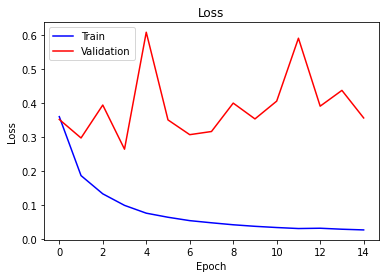

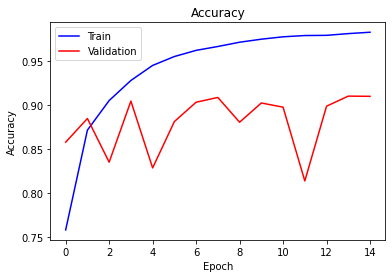

In [9]:
n_timesteps, n_features, n_outputs = training_X.shape[1], training_X.shape[2], training_y_encoded.shape[1]

def define_LSTM_model():
    model = Sequential()
    model.add(LSTM(units = 100, input_shape = (n_timesteps, n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(units = 100, activation = 'relu'))
    model.add(Dense(units = n_outputs, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model
    
def evaluate_model(training_X, training_y_encoded, val_X, val_y_encoded):
    verbose, epochs, batch_size = 1, 15, 64
    model = define_LSTM_model()
    model.summary()
    # Fit network
    history = model.fit(training_X, training_y_encoded, epochs = epochs, batch_size = batch_size, 
              validation_data = (val_X, val_y_encoded), class_weight = label_weights, verbose = verbose)
    # Evaluate model
    _, accuracy = model.evaluate(val_X, val_y_encoded, batch_size = batch_size, verbose = verbose)
    return history, accuracy


# Defining a function for plotting training and validation learning curves
def plot_history(history):
	# Plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # Plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['acc'], color='blue', label='train')
    plt.plot(history.history['val_acc'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

history, accuracy = evaluate_model(training_X, training_y_encoded, val_X, val_y_encoded)
plot_history(history)

In [ ]:
# TODO: Maybe add regularization to our LSTM model
#       Try bidirectional LSTM
#       Create classification report

# Define the dropout grid
dropout_grid = [0.1, 0.5, 0.9]
l1_grid = [2**-5, 2**-6, 2**-7, 2**-8]
l2_grid = [2**-5, 2**-6, 2**-7, 2**-8]
tot = len(dropout_grid) * len(l1_grid) * len(l2_grid)

# Variables for the best result
scores = []
best_history = [] # place holder
best_ind = 0
best_acc = 0

# Loop through each combination
pos = 0
for ii in dropout_grid:
    for jj in l1_grid:
        for kk in l2_grid:
            pos = pos + 1
            print("Fitting the ", pos, "/", tot , " model")
            # define the model
            curr_model = define_LSTM_model(ii, jj, kk)
            #curr_model.summary()
            
            # train the model
            curr_history = curr_model.fit(training_X, training_y_encoded, epochs = 10, 
                                          validation_data = (val_X, val_y_encoded), verbose = 0)
            curr_acc = st.mean(curr_history.history['val_acc'][5:10])
                        
            # get prediction report
            y_pred = curr_model.predict(val_X, batch_size=64, verbose=0)
            y_pred_bool = np.argmax(y_pred, axis=1)
            scores.append(classification_report(val_y, y_pred_bool))
            
            # save the best result
            if best_acc < curr_acc:
                best_acc = curr_acc
                best_ind = pos - 1
                best_history = curr_history

In [ ]:
# TODO: Edit hyperparameters being passed in

# Training a model with ideal hyper-parameters
best_model = define_LSTM_model(0.1, 0.00390625, 0.015625)
best_model.summary()

In [ ]:
# TODO: Fit the best model

# Fit the model
best_history = best_model.fit(training_X, training_y_encoded, epochs = 30, validation_data = (val_X, val_y_encoded), verbose = 1)

In [ ]:
# TODO: Calculate the statistics

# Calculate the stat
curr_acc = st.mean(best_history.history['val_acc'][25:30]) 
print(curr_acc)

# Plot the fit history
plot_history(best_history)

In [ ]:
# TODO: Get prediction report, report F1-score

# Get prediction report
y_pred = best_model.predict(val_X, batch_size=64, verbose=0)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(val_y, y_pred_bool))

In [ ]:
# TODO: Test our model on the test dataset, save results to CSV.